In [2]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR


#### Check cuda is on

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Prints the name of your GPU

True
NVIDIA GeForce RTX 3080 Laptop GPU


# Try with 4 categories naively

In [12]:
FirstData = np.load("FirstData.npy", allow_pickle=True)
print(FirstData.shape)
X = FirstData[:, 1:-1]  # All columns except the last one
y = FirstData[:, -1]    # The last column

Macondition = np.isin(y, ["bC*", "sg*", "s*r", "s*y", "s*b", "WR*", "N*", "Psr"])
y4cat = np.where(Macondition, "Ma*", y)
YOcondition = np.isin(y, ["Or*", "TT*", "out", "Ae*", "HH"])
y4cat = np.where(YOcondition, "Y*O", y4cat)
MScondition = np.isin(y, ["Be*", "BS*", "SX*", "gD*", "dS*"])
y4cat = np.where(MScondition, "MS*", y4cat)
Evcondition = np.isin(y, ["RG*", "HS*", "RR*", "HB*", "WV*", "Ce*", "cC*", "C*", "S*", "LP*", "AS*", "AB*", "Mi*", "OH*", "pA*", "RV*", "PN", "WD*"])
y4cat = np.where(Evcondition, "Ev*", y4cat)

(84674, 14)


# Main AI machine

In [25]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("fullsky4catsgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(y, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.96:
        break

torch.save(model.state_dict(), "star_classifier_Exp1.pth") # Save the model

Running on  cuda  cores


Epoch 1/100: 100%|██████████| 1136/1136 [00:05<00:00, 216.52batch/s, Loss=3.8201]



Test Accuracy after Epoch 1: 0.8952


Epoch 2/100: 100%|██████████| 1136/1136 [00:04<00:00, 240.29batch/s, Loss=3.5911]



Test Accuracy after Epoch 2: 0.8694


Epoch 3/100: 100%|██████████| 1136/1136 [00:04<00:00, 237.07batch/s, Loss=3.5695]



Test Accuracy after Epoch 3: 0.9068


Epoch 4/100: 100%|██████████| 1136/1136 [00:04<00:00, 252.36batch/s, Loss=3.5066]



Test Accuracy after Epoch 4: 0.9253


Epoch 5/100: 100%|██████████| 1136/1136 [00:04<00:00, 255.95batch/s, Loss=3.4928]



Test Accuracy after Epoch 5: 0.8803


Epoch 6/100: 100%|██████████| 1136/1136 [00:04<00:00, 249.84batch/s, Loss=3.4837]



Test Accuracy after Epoch 6: 0.9206


Epoch 7/100: 100%|██████████| 1136/1136 [00:04<00:00, 262.35batch/s, Loss=3.4548]



Test Accuracy after Epoch 7: 0.9308


Epoch 8/100: 100%|██████████| 1136/1136 [00:04<00:00, 253.06batch/s, Loss=3.5479]



Test Accuracy after Epoch 8: 0.8925


Epoch 9/100: 100%|██████████| 1136/1136 [00:04<00:00, 244.93batch/s, Loss=3.4896]



Test Accuracy after Epoch 9: 0.9336


Epoch 10/100: 100%|██████████| 1136/1136 [00:04<00:00, 250.00batch/s, Loss=3.4642]



Test Accuracy after Epoch 10: 0.8414


Epoch 11/100: 100%|██████████| 1136/1136 [00:04<00:00, 243.00batch/s, Loss=3.4521]



Test Accuracy after Epoch 11: 0.9034


Epoch 12/100: 100%|██████████| 1136/1136 [00:04<00:00, 257.75batch/s, Loss=3.5590]



Test Accuracy after Epoch 12: 0.9261


Epoch 13/100: 100%|██████████| 1136/1136 [00:04<00:00, 246.41batch/s, Loss=3.5361]



Test Accuracy after Epoch 13: 0.8821


Epoch 14/100: 100%|██████████| 1136/1136 [00:04<00:00, 236.98batch/s, Loss=3.4872]



Test Accuracy after Epoch 14: 0.8943


Epoch 15/100: 100%|██████████| 1136/1136 [00:04<00:00, 248.83batch/s, Loss=3.4560]



Test Accuracy after Epoch 15: 0.9388


Epoch 16/100: 100%|██████████| 1136/1136 [00:04<00:00, 237.92batch/s, Loss=3.4877]



Test Accuracy after Epoch 16: 0.8651


Epoch 17/100: 100%|██████████| 1136/1136 [00:04<00:00, 249.24batch/s, Loss=3.4335]



Test Accuracy after Epoch 17: 0.9257


Epoch 18/100: 100%|██████████| 1136/1136 [00:04<00:00, 252.79batch/s, Loss=3.4358]



Test Accuracy after Epoch 18: 0.9291


Epoch 19/100: 100%|██████████| 1136/1136 [00:04<00:00, 227.75batch/s, Loss=3.6152]



Test Accuracy after Epoch 19: 0.9359


Epoch 20/100: 100%|██████████| 1136/1136 [00:04<00:00, 245.80batch/s, Loss=3.5360]



Test Accuracy after Epoch 20: 0.9365


Epoch 21/100: 100%|██████████| 1136/1136 [00:04<00:00, 245.11batch/s, Loss=3.4487]



Test Accuracy after Epoch 21: 0.9175


Epoch 22/100: 100%|██████████| 1136/1136 [00:05<00:00, 213.98batch/s, Loss=3.4493]



Test Accuracy after Epoch 22: 0.9388


Epoch 23/100: 100%|██████████| 1136/1136 [00:04<00:00, 232.50batch/s, Loss=3.5450]



Test Accuracy after Epoch 23: 0.8614


Epoch 24/100: 100%|██████████| 1136/1136 [00:05<00:00, 224.45batch/s, Loss=3.4421]



Test Accuracy after Epoch 24: 0.9223


Epoch 25/100: 100%|██████████| 1136/1136 [00:04<00:00, 229.34batch/s, Loss=3.4382]



Test Accuracy after Epoch 25: 0.9364


Epoch 26/100: 100%|██████████| 1136/1136 [00:04<00:00, 238.30batch/s, Loss=3.4554]



Test Accuracy after Epoch 26: 0.9267


Epoch 27/100: 100%|██████████| 1136/1136 [00:04<00:00, 244.10batch/s, Loss=3.5505]



Test Accuracy after Epoch 27: 0.9147


Epoch 28/100: 100%|██████████| 1136/1136 [00:04<00:00, 234.36batch/s, Loss=3.5033]



Test Accuracy after Epoch 28: 0.8958


Epoch 29/100: 100%|██████████| 1136/1136 [00:04<00:00, 259.92batch/s, Loss=3.4254]



Test Accuracy after Epoch 29: 0.9433


Epoch 30/100: 100%|██████████| 1136/1136 [00:04<00:00, 253.36batch/s, Loss=3.5837]



Test Accuracy after Epoch 30: 0.9398


Epoch 31/100: 100%|██████████| 1136/1136 [00:04<00:00, 259.54batch/s, Loss=3.7074]



Test Accuracy after Epoch 31: 0.9155


Epoch 32/100: 100%|██████████| 1136/1136 [00:05<00:00, 213.69batch/s, Loss=3.4734]



Test Accuracy after Epoch 32: 0.9281


Epoch 33/100: 100%|██████████| 1136/1136 [00:05<00:00, 214.93batch/s, Loss=3.5225]



Test Accuracy after Epoch 33: 0.9292


Epoch 34/100: 100%|██████████| 1136/1136 [00:05<00:00, 224.01batch/s, Loss=3.4393]



Test Accuracy after Epoch 34: 0.9299


Epoch 35/100: 100%|██████████| 1136/1136 [00:04<00:00, 235.41batch/s, Loss=3.4622]



Test Accuracy after Epoch 35: 0.9165


Epoch 36/100: 100%|██████████| 1136/1136 [00:04<00:00, 233.27batch/s, Loss=3.4878]



Test Accuracy after Epoch 36: 0.9227


Epoch 37/100: 100%|██████████| 1136/1136 [00:04<00:00, 238.68batch/s, Loss=3.4453]



Test Accuracy after Epoch 37: 0.9058


Epoch 38/100: 100%|██████████| 1136/1136 [00:04<00:00, 233.09batch/s, Loss=3.4376]



Test Accuracy after Epoch 38: 0.9062


Epoch 39/100: 100%|██████████| 1136/1136 [00:05<00:00, 205.31batch/s, Loss=3.4458]



Test Accuracy after Epoch 39: 0.9467


Epoch 40/100: 100%|██████████| 1136/1136 [00:05<00:00, 224.54batch/s, Loss=3.4785]



Test Accuracy after Epoch 40: 0.9147


Epoch 41/100: 100%|██████████| 1136/1136 [00:05<00:00, 218.36batch/s, Loss=3.5299]



Test Accuracy after Epoch 41: 0.9322


Epoch 42/100: 100%|██████████| 1136/1136 [00:04<00:00, 234.28batch/s, Loss=3.4904]



Test Accuracy after Epoch 42: 0.9382


Epoch 43/100: 100%|██████████| 1136/1136 [00:05<00:00, 223.79batch/s, Loss=3.6023]



Test Accuracy after Epoch 43: 0.9369


Epoch 44/100: 100%|██████████| 1136/1136 [00:05<00:00, 216.56batch/s, Loss=3.4865]



Test Accuracy after Epoch 44: 0.9146


Epoch 45/100: 100%|██████████| 1136/1136 [00:04<00:00, 246.30batch/s, Loss=3.4502]



Test Accuracy after Epoch 45: 0.9371


Epoch 46/100: 100%|██████████| 1136/1136 [00:05<00:00, 207.16batch/s, Loss=3.4883]



Test Accuracy after Epoch 46: 0.9483


Epoch 47/100: 100%|██████████| 1136/1136 [00:06<00:00, 172.62batch/s, Loss=3.4805]



Test Accuracy after Epoch 47: 0.9596


Epoch 48/100: 100%|██████████| 1136/1136 [00:06<00:00, 172.26batch/s, Loss=3.5087]



Test Accuracy after Epoch 48: 0.9072


Epoch 49/100: 100%|██████████| 1136/1136 [00:06<00:00, 169.87batch/s, Loss=3.4932]



Test Accuracy after Epoch 49: 0.9355


Epoch 50/100: 100%|██████████| 1136/1136 [00:06<00:00, 169.87batch/s, Loss=3.4959]



Test Accuracy after Epoch 50: 0.9487


Epoch 51/100: 100%|██████████| 1136/1136 [00:06<00:00, 170.20batch/s, Loss=3.5164]



Test Accuracy after Epoch 51: 0.8987


Epoch 52/100: 100%|██████████| 1136/1136 [00:06<00:00, 167.15batch/s, Loss=3.5377]



Test Accuracy after Epoch 52: 0.9436


Epoch 53/100: 100%|██████████| 1136/1136 [00:06<00:00, 172.65batch/s, Loss=3.6633]



Test Accuracy after Epoch 53: 0.8666


Epoch 54/100: 100%|██████████| 1136/1136 [00:06<00:00, 168.61batch/s, Loss=3.6891]



Test Accuracy after Epoch 54: 0.9515


Epoch 55/100: 100%|██████████| 1136/1136 [00:06<00:00, 171.24batch/s, Loss=3.5615]



Test Accuracy after Epoch 55: 0.9578


Epoch 56/100: 100%|██████████| 1136/1136 [00:06<00:00, 172.11batch/s, Loss=3.6171]



Test Accuracy after Epoch 56: 0.9424


Epoch 57/100: 100%|██████████| 1136/1136 [00:06<00:00, 173.00batch/s, Loss=3.9207]



Test Accuracy after Epoch 57: 0.9445


Epoch 58/100: 100%|██████████| 1136/1136 [00:06<00:00, 165.04batch/s, Loss=3.8558]



Test Accuracy after Epoch 58: 0.9370


Epoch 59/100: 100%|██████████| 1136/1136 [00:06<00:00, 165.94batch/s, Loss=3.7621]



Test Accuracy after Epoch 59: 0.9437


Epoch 60/100: 100%|██████████| 1136/1136 [00:06<00:00, 164.56batch/s, Loss=3.5458]



Test Accuracy after Epoch 60: 0.9553


Epoch 61/100: 100%|██████████| 1136/1136 [00:06<00:00, 167.88batch/s, Loss=3.5853]



Test Accuracy after Epoch 61: 0.9424


Epoch 62/100: 100%|██████████| 1136/1136 [00:06<00:00, 170.91batch/s, Loss=3.4930]



Test Accuracy after Epoch 62: 0.9536


Epoch 63/100: 100%|██████████| 1136/1136 [00:06<00:00, 173.24batch/s, Loss=3.4555]



Test Accuracy after Epoch 63: 0.9344


Epoch 64/100: 100%|██████████| 1136/1136 [00:07<00:00, 159.73batch/s, Loss=3.4355]



Test Accuracy after Epoch 64: 0.9223


Epoch 65/100: 100%|██████████| 1136/1136 [00:06<00:00, 168.97batch/s, Loss=3.4418]



Test Accuracy after Epoch 65: 0.8892


Epoch 66/100: 100%|██████████| 1136/1136 [00:06<00:00, 168.09batch/s, Loss=3.4637]



Test Accuracy after Epoch 66: 0.9489


Epoch 67/100: 100%|██████████| 1136/1136 [00:06<00:00, 169.65batch/s, Loss=3.5021]



Test Accuracy after Epoch 67: 0.9039


Epoch 68/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.25batch/s, Loss=3.4869]



Test Accuracy after Epoch 68: 0.9027


Epoch 69/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.51batch/s, Loss=3.4660]



Test Accuracy after Epoch 69: 0.9147


Epoch 70/100: 100%|██████████| 1136/1136 [00:06<00:00, 169.33batch/s, Loss=3.4877]



Test Accuracy after Epoch 70: 0.9141


Epoch 71/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.37batch/s, Loss=3.4600]



Test Accuracy after Epoch 71: 0.9340


Epoch 72/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.48batch/s, Loss=3.4546]



Test Accuracy after Epoch 72: 0.9235


Epoch 73/100: 100%|██████████| 1136/1136 [00:06<00:00, 177.61batch/s, Loss=3.4307]



Test Accuracy after Epoch 73: 0.8911


Epoch 74/100: 100%|██████████| 1136/1136 [00:06<00:00, 177.47batch/s, Loss=3.4819]



Test Accuracy after Epoch 74: 0.9305


Epoch 75/100: 100%|██████████| 1136/1136 [00:06<00:00, 175.39batch/s, Loss=3.4620]



Test Accuracy after Epoch 75: 0.9228


Epoch 76/100: 100%|██████████| 1136/1136 [00:06<00:00, 175.65batch/s, Loss=3.4858]



Test Accuracy after Epoch 76: 0.9371


Epoch 77/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.76batch/s, Loss=3.6846]



Test Accuracy after Epoch 77: 0.9580


Epoch 78/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.19batch/s, Loss=3.6022]



Test Accuracy after Epoch 78: 0.9292


Epoch 79/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.62batch/s, Loss=3.5807]



Test Accuracy after Epoch 79: 0.9228


Epoch 80/100: 100%|██████████| 1136/1136 [00:06<00:00, 175.03batch/s, Loss=3.4987]



Test Accuracy after Epoch 80: 0.9545


Epoch 81/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.86batch/s, Loss=3.6638]



Test Accuracy after Epoch 81: 0.9261


Epoch 82/100: 100%|██████████| 1136/1136 [00:06<00:00, 173.16batch/s, Loss=3.6933]



Test Accuracy after Epoch 82: 0.9541


Epoch 83/100: 100%|██████████| 1136/1136 [00:06<00:00, 176.12batch/s, Loss=3.6260]



Test Accuracy after Epoch 83: 0.8922


Epoch 84/100: 100%|██████████| 1136/1136 [00:06<00:00, 175.35batch/s, Loss=3.5914]



Test Accuracy after Epoch 84: 0.9218


Epoch 85/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.89batch/s, Loss=3.5151]



Test Accuracy after Epoch 85: 0.8941


Epoch 86/100: 100%|██████████| 1136/1136 [00:06<00:00, 173.36batch/s, Loss=3.4802]



Test Accuracy after Epoch 86: 0.9360


Epoch 87/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.34batch/s, Loss=3.5117]



Test Accuracy after Epoch 87: 0.9402


Epoch 88/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.30batch/s, Loss=3.5038]



Test Accuracy after Epoch 88: 0.9079


Epoch 89/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.31batch/s, Loss=3.5135]



Test Accuracy after Epoch 89: 0.9316


Epoch 90/100: 100%|██████████| 1136/1136 [00:06<00:00, 174.92batch/s, Loss=3.4656]



Test Accuracy after Epoch 90: 0.8747


Epoch 91/100: 100%|██████████| 1136/1136 [00:06<00:00, 184.79batch/s, Loss=3.5124]



Test Accuracy after Epoch 91: 0.9111


Epoch 92/100: 100%|██████████| 1136/1136 [00:06<00:00, 184.30batch/s, Loss=3.5140]



Test Accuracy after Epoch 92: 0.8881


Epoch 93/100: 100%|██████████| 1136/1136 [00:06<00:00, 188.87batch/s, Loss=3.5324]



Test Accuracy after Epoch 93: 0.9487


Epoch 94/100: 100%|██████████| 1136/1136 [00:06<00:00, 184.37batch/s, Loss=3.4909]



Test Accuracy after Epoch 94: 0.9090


Epoch 95/100: 100%|██████████| 1136/1136 [00:06<00:00, 183.54batch/s, Loss=3.4569]



Test Accuracy after Epoch 95: 0.9306


Epoch 96/100: 100%|██████████| 1136/1136 [00:06<00:00, 177.22batch/s, Loss=3.4858]



Test Accuracy after Epoch 96: 0.9308


Epoch 97/100: 100%|██████████| 1136/1136 [00:06<00:00, 188.14batch/s, Loss=3.5446]



Test Accuracy after Epoch 97: 0.9414


Epoch 98/100: 100%|██████████| 1136/1136 [00:06<00:00, 184.69batch/s, Loss=3.6026]



Test Accuracy after Epoch 98: 0.9464


Epoch 99/100: 100%|██████████| 1136/1136 [00:06<00:00, 182.87batch/s, Loss=3.7442]



Test Accuracy after Epoch 99: 0.9311


Epoch 100/100: 100%|██████████| 1136/1136 [00:05<00:00, 189.51batch/s, Loss=3.6117]



Test Accuracy after Epoch 100: 0.9149


C:\Users\jcwin\AppData\Local\Temp\ipykernel_14532\200739564.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('star_classifier_Exp1.pth'))

Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.92      0.96     11092
         MS*       0.19      0.91      0.31       168
         Ma*       0.22      0.86      0.34        78
         Y*O       0.87      0.90      0.88       779

    accuracy                           0.91     12117
   macro avg       0.57      0.90      0.62     12117
weighted avg       0.97      0.91      0.94     12117



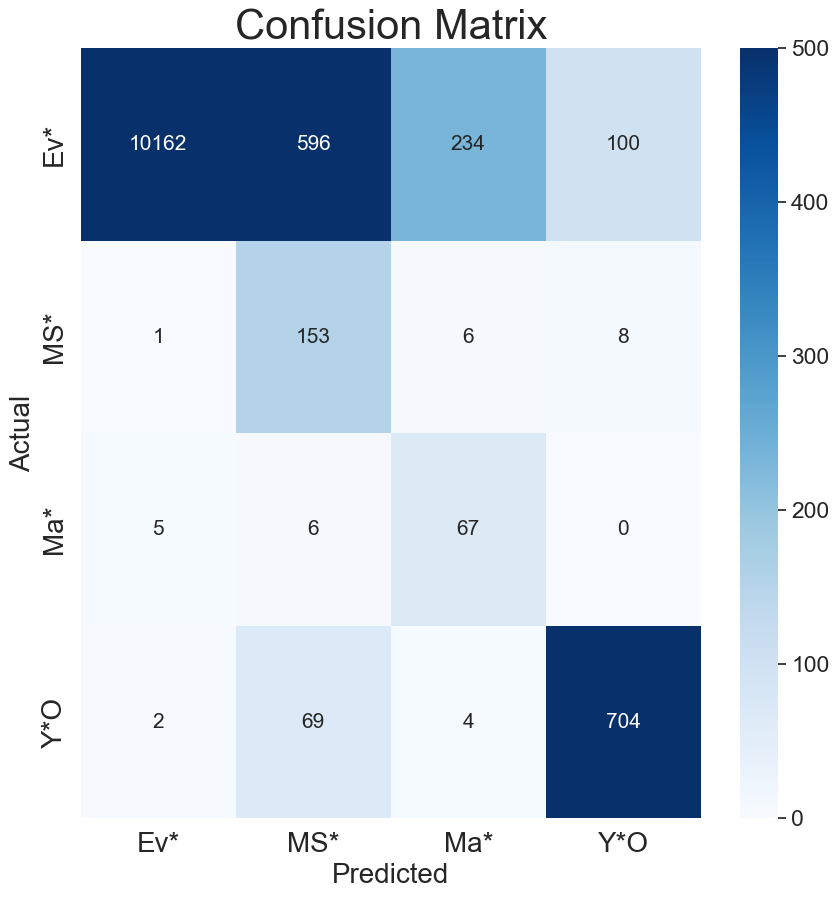

In [28]:
# Load the saved model
model.load_state_dict(torch.load('star_classifier_Exp1.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Large batch size, many epochs all classes

In [27]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("fullsky4catsgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
ypostencode = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(ypostencode, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 400
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.97:
        break
torch.save(model.state_dict(), "star_classifier_Exp2.pth") # Save the model


Running on  cuda  cores


Epoch 1/400: 100%|██████████| 142/142 [00:00<00:00, 175.89batch/s, Loss=4.3847]



Test Accuracy after Epoch 1: 0.8669


Epoch 2/400: 100%|██████████| 142/142 [00:00<00:00, 163.93batch/s, Loss=3.5696]



Test Accuracy after Epoch 2: 0.8057


Epoch 3/400: 100%|██████████| 142/142 [00:00<00:00, 171.74batch/s, Loss=3.5386]



Test Accuracy after Epoch 3: 0.8659


Epoch 4/400: 100%|██████████| 142/142 [00:00<00:00, 163.20batch/s, Loss=3.5701]



Test Accuracy after Epoch 4: 0.8866


Epoch 5/400: 100%|██████████| 142/142 [00:00<00:00, 178.53batch/s, Loss=3.4635]



Test Accuracy after Epoch 5: 0.9070


Epoch 6/400: 100%|██████████| 142/142 [00:00<00:00, 174.15batch/s, Loss=3.4634]



Test Accuracy after Epoch 6: 0.9204


Epoch 7/400: 100%|██████████| 142/142 [00:00<00:00, 175.72batch/s, Loss=3.4700]



Test Accuracy after Epoch 7: 0.9192


Epoch 8/400: 100%|██████████| 142/142 [00:00<00:00, 143.20batch/s, Loss=3.4349]



Test Accuracy after Epoch 8: 0.9227


Epoch 9/400: 100%|██████████| 142/142 [00:00<00:00, 175.42batch/s, Loss=3.4245]



Test Accuracy after Epoch 9: 0.9323


Epoch 10/400: 100%|██████████| 142/142 [00:00<00:00, 177.54batch/s, Loss=3.4268]



Test Accuracy after Epoch 10: 0.9302


Epoch 11/400: 100%|██████████| 142/142 [00:00<00:00, 175.82batch/s, Loss=3.4207]



Test Accuracy after Epoch 11: 0.9264


Epoch 12/400: 100%|██████████| 142/142 [00:00<00:00, 174.59batch/s, Loss=3.4059]



Test Accuracy after Epoch 12: 0.9180


Epoch 13/400: 100%|██████████| 142/142 [00:00<00:00, 145.26batch/s, Loss=3.3946]



Test Accuracy after Epoch 13: 0.9350


Epoch 14/400: 100%|██████████| 142/142 [00:00<00:00, 171.98batch/s, Loss=3.4143]



Test Accuracy after Epoch 14: 0.9156


Epoch 15/400: 100%|██████████| 142/142 [00:00<00:00, 175.01batch/s, Loss=3.4022]



Test Accuracy after Epoch 15: 0.9398


Epoch 16/400: 100%|██████████| 142/142 [00:00<00:00, 178.03batch/s, Loss=3.4200]



Test Accuracy after Epoch 16: 0.9380


Epoch 17/400: 100%|██████████| 142/142 [00:00<00:00, 160.51batch/s, Loss=3.4366]



Test Accuracy after Epoch 17: 0.9170


Epoch 18/400: 100%|██████████| 142/142 [00:00<00:00, 167.92batch/s, Loss=3.4141]



Test Accuracy after Epoch 18: 0.9232


Epoch 19/400: 100%|██████████| 142/142 [00:00<00:00, 179.12batch/s, Loss=3.4171]



Test Accuracy after Epoch 19: 0.9399


Epoch 20/400: 100%|██████████| 142/142 [00:00<00:00, 177.50batch/s, Loss=3.4015]



Test Accuracy after Epoch 20: 0.9445


Epoch 21/400: 100%|██████████| 142/142 [00:00<00:00, 179.80batch/s, Loss=3.4134]



Test Accuracy after Epoch 21: 0.9359


Epoch 22/400: 100%|██████████| 142/142 [00:00<00:00, 144.64batch/s, Loss=3.3843]



Test Accuracy after Epoch 22: 0.9469


Epoch 23/400: 100%|██████████| 142/142 [00:00<00:00, 177.31batch/s, Loss=3.3848]



Test Accuracy after Epoch 23: 0.9425


Epoch 24/400: 100%|██████████| 142/142 [00:00<00:00, 175.25batch/s, Loss=3.4115]



Test Accuracy after Epoch 24: 0.9314


Epoch 25/400: 100%|██████████| 142/142 [00:00<00:00, 179.27batch/s, Loss=3.3832]



Test Accuracy after Epoch 25: 0.9348


Epoch 26/400: 100%|██████████| 142/142 [00:00<00:00, 177.12batch/s, Loss=3.3998]



Test Accuracy after Epoch 26: 0.9238


Epoch 27/400: 100%|██████████| 142/142 [00:00<00:00, 144.06batch/s, Loss=3.3902]



Test Accuracy after Epoch 27: 0.9332


Epoch 28/400: 100%|██████████| 142/142 [00:00<00:00, 178.14batch/s, Loss=3.3772]



Test Accuracy after Epoch 28: 0.9294


Epoch 29/400: 100%|██████████| 142/142 [00:00<00:00, 178.39batch/s, Loss=3.4015]



Test Accuracy after Epoch 29: 0.9347


Epoch 30/400: 100%|██████████| 142/142 [00:00<00:00, 180.72batch/s, Loss=3.3470]



Test Accuracy after Epoch 30: 0.9304


Epoch 31/400: 100%|██████████| 142/142 [00:00<00:00, 151.68batch/s, Loss=3.3950]



Test Accuracy after Epoch 31: 0.9366


Epoch 32/400: 100%|██████████| 142/142 [00:00<00:00, 175.57batch/s, Loss=3.4111]



Test Accuracy after Epoch 32: 0.9379


Epoch 33/400: 100%|██████████| 142/142 [00:00<00:00, 174.07batch/s, Loss=3.3793]



Test Accuracy after Epoch 33: 0.9383


Epoch 34/400: 100%|██████████| 142/142 [00:00<00:00, 178.29batch/s, Loss=3.4067]



Test Accuracy after Epoch 34: 0.9334


Epoch 35/400: 100%|██████████| 142/142 [00:00<00:00, 178.99batch/s, Loss=3.3915]



Test Accuracy after Epoch 35: 0.9574


Epoch 36/400: 100%|██████████| 142/142 [00:00<00:00, 143.68batch/s, Loss=3.3869]



Test Accuracy after Epoch 36: 0.9309


Epoch 37/400: 100%|██████████| 142/142 [00:00<00:00, 180.71batch/s, Loss=3.3731]



Test Accuracy after Epoch 37: 0.9262


Epoch 38/400: 100%|██████████| 142/142 [00:00<00:00, 151.47batch/s, Loss=3.3887]



Test Accuracy after Epoch 38: 0.9524


Epoch 39/400: 100%|██████████| 142/142 [00:00<00:00, 150.59batch/s, Loss=3.4181]



Test Accuracy after Epoch 39: 0.9453


Epoch 40/400: 100%|██████████| 142/142 [00:01<00:00, 115.96batch/s, Loss=3.4664]



Test Accuracy after Epoch 40: 0.9301


Epoch 41/400: 100%|██████████| 142/142 [00:01<00:00, 141.09batch/s, Loss=3.3756]



Test Accuracy after Epoch 41: 0.9563


Epoch 42/400: 100%|██████████| 142/142 [00:00<00:00, 154.78batch/s, Loss=3.4259]



Test Accuracy after Epoch 42: 0.9341


Epoch 43/400: 100%|██████████| 142/142 [00:00<00:00, 146.83batch/s, Loss=3.3589]



Test Accuracy after Epoch 43: 0.9469


Epoch 44/400: 100%|██████████| 142/142 [00:00<00:00, 153.04batch/s, Loss=3.3508]



Test Accuracy after Epoch 44: 0.9405


Epoch 45/400: 100%|██████████| 142/142 [00:01<00:00, 121.48batch/s, Loss=3.3896]



Test Accuracy after Epoch 45: 0.9445


Epoch 46/400: 100%|██████████| 142/142 [00:00<00:00, 152.54batch/s, Loss=3.3592]



Test Accuracy after Epoch 46: 0.9491


Epoch 47/400: 100%|██████████| 142/142 [00:00<00:00, 152.66batch/s, Loss=3.3203]



Test Accuracy after Epoch 47: 0.9521


Epoch 48/400: 100%|██████████| 142/142 [00:00<00:00, 150.50batch/s, Loss=3.3498]



Test Accuracy after Epoch 48: 0.9475


Epoch 49/400: 100%|██████████| 142/142 [00:01<00:00, 141.68batch/s, Loss=3.3716]



Test Accuracy after Epoch 49: 0.9527


Epoch 50/400: 100%|██████████| 142/142 [00:00<00:00, 150.81batch/s, Loss=3.3676]



Test Accuracy after Epoch 50: 0.9502


Epoch 51/400: 100%|██████████| 142/142 [00:00<00:00, 151.06batch/s, Loss=3.3478]



Test Accuracy after Epoch 51: 0.9542


Epoch 52/400: 100%|██████████| 142/142 [00:00<00:00, 152.30batch/s, Loss=3.3437]



Test Accuracy after Epoch 52: 0.9579


Epoch 53/400: 100%|██████████| 142/142 [00:00<00:00, 153.35batch/s, Loss=3.3594]



Test Accuracy after Epoch 53: 0.9448


Epoch 54/400: 100%|██████████| 142/142 [00:01<00:00, 124.42batch/s, Loss=3.3260]



Test Accuracy after Epoch 54: 0.9459


Epoch 55/400: 100%|██████████| 142/142 [00:00<00:00, 147.58batch/s, Loss=3.3292]



Test Accuracy after Epoch 55: 0.9587


Epoch 56/400: 100%|██████████| 142/142 [00:00<00:00, 152.59batch/s, Loss=3.3493]



Test Accuracy after Epoch 56: 0.9473


Epoch 57/400: 100%|██████████| 142/142 [00:00<00:00, 152.99batch/s, Loss=3.3193]



Test Accuracy after Epoch 57: 0.9533


Epoch 58/400: 100%|██████████| 142/142 [00:01<00:00, 138.45batch/s, Loss=3.3520]



Test Accuracy after Epoch 58: 0.9390


Epoch 59/400: 100%|██████████| 142/142 [00:00<00:00, 146.50batch/s, Loss=3.3260]



Test Accuracy after Epoch 59: 0.9394


Epoch 60/400: 100%|██████████| 142/142 [00:00<00:00, 153.08batch/s, Loss=3.3534]



Test Accuracy after Epoch 60: 0.9522


Epoch 61/400: 100%|██████████| 142/142 [00:01<00:00, 122.72batch/s, Loss=3.3263]



Test Accuracy after Epoch 61: 0.9577


Epoch 62/400: 100%|██████████| 142/142 [00:00<00:00, 152.67batch/s, Loss=3.3318]



Test Accuracy after Epoch 62: 0.9543


Epoch 63/400: 100%|██████████| 142/142 [00:01<00:00, 125.24batch/s, Loss=3.3291]



Test Accuracy after Epoch 63: 0.9526


Epoch 64/400: 100%|██████████| 142/142 [00:00<00:00, 150.48batch/s, Loss=3.3367]



Test Accuracy after Epoch 64: 0.9588


Epoch 65/400: 100%|██████████| 142/142 [00:00<00:00, 148.20batch/s, Loss=3.3105]



Test Accuracy after Epoch 65: 0.9563


Epoch 66/400: 100%|██████████| 142/142 [00:00<00:00, 151.59batch/s, Loss=3.3316]



Test Accuracy after Epoch 66: 0.9483


Epoch 67/400: 100%|██████████| 142/142 [00:01<00:00, 132.06batch/s, Loss=3.3478]



Test Accuracy after Epoch 67: 0.9381


Epoch 68/400: 100%|██████████| 142/142 [00:00<00:00, 144.49batch/s, Loss=3.3540]



Test Accuracy after Epoch 68: 0.9585


Epoch 69/400: 100%|██████████| 142/142 [00:00<00:00, 149.10batch/s, Loss=3.3650]



Test Accuracy after Epoch 69: 0.9295


Epoch 70/400: 100%|██████████| 142/142 [00:00<00:00, 148.78batch/s, Loss=3.3934]



Test Accuracy after Epoch 70: 0.9605


Epoch 71/400: 100%|██████████| 142/142 [00:00<00:00, 150.50batch/s, Loss=3.3486]



Test Accuracy after Epoch 71: 0.9580


Epoch 72/400: 100%|██████████| 142/142 [00:01<00:00, 122.44batch/s, Loss=3.3441]



Test Accuracy after Epoch 72: 0.9494


Epoch 73/400: 100%|██████████| 142/142 [00:01<00:00, 119.93batch/s, Loss=3.3377]



Test Accuracy after Epoch 73: 0.9547


Epoch 74/400: 100%|██████████| 142/142 [00:00<00:00, 153.93batch/s, Loss=3.3462]



Test Accuracy after Epoch 74: 0.9492


Epoch 75/400: 100%|██████████| 142/142 [00:00<00:00, 163.90batch/s, Loss=3.3254]



Test Accuracy after Epoch 75: 0.9561


Epoch 76/400: 100%|██████████| 142/142 [00:00<00:00, 146.48batch/s, Loss=3.3253]



Test Accuracy after Epoch 76: 0.9597


Epoch 77/400: 100%|██████████| 142/142 [00:00<00:00, 165.68batch/s, Loss=3.3658]



Test Accuracy after Epoch 77: 0.9044


Epoch 78/400: 100%|██████████| 142/142 [00:00<00:00, 161.23batch/s, Loss=3.3601]



Test Accuracy after Epoch 78: 0.9310


Epoch 79/400: 100%|██████████| 142/142 [00:00<00:00, 158.43batch/s, Loss=3.3487]



Test Accuracy after Epoch 79: 0.9480


Epoch 80/400: 100%|██████████| 142/142 [00:00<00:00, 165.37batch/s, Loss=3.3429]



Test Accuracy after Epoch 80: 0.9308


Epoch 81/400: 100%|██████████| 142/142 [00:01<00:00, 131.26batch/s, Loss=3.3542]



Test Accuracy after Epoch 81: 0.9475


Epoch 82/400: 100%|██████████| 142/142 [00:00<00:00, 162.95batch/s, Loss=3.3243]



Test Accuracy after Epoch 82: 0.9554


Epoch 83/400: 100%|██████████| 142/142 [00:00<00:00, 161.05batch/s, Loss=3.3444]



Test Accuracy after Epoch 83: 0.9390


Epoch 84/400: 100%|██████████| 142/142 [00:00<00:00, 162.42batch/s, Loss=3.3302]



Test Accuracy after Epoch 84: 0.9587


Epoch 85/400: 100%|██████████| 142/142 [00:01<00:00, 120.14batch/s, Loss=3.3203]



Test Accuracy after Epoch 85: 0.9334


Epoch 86/400: 100%|██████████| 142/142 [00:00<00:00, 159.72batch/s, Loss=3.3615]



Test Accuracy after Epoch 86: 0.9539


Epoch 87/400: 100%|██████████| 142/142 [00:00<00:00, 162.27batch/s, Loss=3.3289]



Test Accuracy after Epoch 87: 0.9558


Epoch 88/400: 100%|██████████| 142/142 [00:00<00:00, 159.84batch/s, Loss=3.3425]



Test Accuracy after Epoch 88: 0.9388


Epoch 89/400: 100%|██████████| 142/142 [00:00<00:00, 164.57batch/s, Loss=3.3393]



Test Accuracy after Epoch 89: 0.9497


Epoch 90/400: 100%|██████████| 142/142 [00:01<00:00, 129.30batch/s, Loss=3.3330]



Test Accuracy after Epoch 90: 0.9586


Epoch 91/400: 100%|██████████| 142/142 [00:00<00:00, 163.93batch/s, Loss=3.3162]



Test Accuracy after Epoch 91: 0.9549


Epoch 92/400: 100%|██████████| 142/142 [00:00<00:00, 159.03batch/s, Loss=3.3073]



Test Accuracy after Epoch 92: 0.9510


Epoch 93/400: 100%|██████████| 142/142 [00:00<00:00, 161.85batch/s, Loss=3.3322]



Test Accuracy after Epoch 93: 0.9406


Epoch 94/400: 100%|██████████| 142/142 [00:00<00:00, 155.84batch/s, Loss=3.4632]



Test Accuracy after Epoch 94: 0.9487


Epoch 95/400: 100%|██████████| 142/142 [00:00<00:00, 151.12batch/s, Loss=3.4222]



Test Accuracy after Epoch 95: 0.9521


Epoch 96/400: 100%|██████████| 142/142 [00:00<00:00, 159.98batch/s, Loss=3.3405]



Test Accuracy after Epoch 96: 0.9440


Epoch 97/400: 100%|██████████| 142/142 [00:01<00:00, 127.13batch/s, Loss=3.3243]



Test Accuracy after Epoch 97: 0.9640


Epoch 98/400: 100%|██████████| 142/142 [00:00<00:00, 160.56batch/s, Loss=3.3466]



Test Accuracy after Epoch 98: 0.9258


Epoch 99/400: 100%|██████████| 142/142 [00:01<00:00, 130.59batch/s, Loss=3.3812]



Test Accuracy after Epoch 99: 0.9485


Epoch 100/400: 100%|██████████| 142/142 [00:00<00:00, 158.51batch/s, Loss=3.3453]



Test Accuracy after Epoch 100: 0.9497


Epoch 101/400: 100%|██████████| 142/142 [00:00<00:00, 159.67batch/s, Loss=3.3663]



Test Accuracy after Epoch 101: 0.9620


Epoch 102/400: 100%|██████████| 142/142 [00:00<00:00, 162.64batch/s, Loss=3.3413]



Test Accuracy after Epoch 102: 0.9595


Epoch 103/400: 100%|██████████| 142/142 [00:00<00:00, 156.03batch/s, Loss=3.3235]



Test Accuracy after Epoch 103: 0.9595


Epoch 104/400: 100%|██████████| 142/142 [00:00<00:00, 147.27batch/s, Loss=3.3473]



Test Accuracy after Epoch 104: 0.9254


Epoch 105/400: 100%|██████████| 142/142 [00:00<00:00, 161.92batch/s, Loss=3.3414]



Test Accuracy after Epoch 105: 0.9352


Epoch 106/400: 100%|██████████| 142/142 [00:00<00:00, 160.15batch/s, Loss=3.3361]



Test Accuracy after Epoch 106: 0.9450


Epoch 107/400: 100%|██████████| 142/142 [00:00<00:00, 162.45batch/s, Loss=3.3550]



Test Accuracy after Epoch 107: 0.9573


Epoch 108/400: 100%|██████████| 142/142 [00:01<00:00, 133.12batch/s, Loss=3.3515]



Test Accuracy after Epoch 108: 0.9278


Epoch 109/400: 100%|██████████| 142/142 [00:01<00:00, 125.73batch/s, Loss=3.3333]



Test Accuracy after Epoch 109: 0.9436


Epoch 110/400: 100%|██████████| 142/142 [00:00<00:00, 160.60batch/s, Loss=3.3315]



Test Accuracy after Epoch 110: 0.9506


Epoch 111/400: 100%|██████████| 142/142 [00:00<00:00, 160.54batch/s, Loss=3.3173]



Test Accuracy after Epoch 111: 0.9535


Epoch 112/400: 100%|██████████| 142/142 [00:00<00:00, 166.22batch/s, Loss=3.3227]



Test Accuracy after Epoch 112: 0.9554


Epoch 113/400: 100%|██████████| 142/142 [00:01<00:00, 132.05batch/s, Loss=3.3202]



Test Accuracy after Epoch 113: 0.9601


Epoch 114/400: 100%|██████████| 142/142 [00:00<00:00, 161.64batch/s, Loss=3.3204]



Test Accuracy after Epoch 114: 0.9603


Epoch 115/400: 100%|██████████| 142/142 [00:00<00:00, 158.01batch/s, Loss=3.3110]



Test Accuracy after Epoch 115: 0.9584


Epoch 116/400: 100%|██████████| 142/142 [00:00<00:00, 158.45batch/s, Loss=3.3347]



Test Accuracy after Epoch 116: 0.9156


Epoch 117/400: 100%|██████████| 142/142 [00:01<00:00, 139.24batch/s, Loss=3.3741]



Test Accuracy after Epoch 117: 0.9434


Epoch 118/400: 100%|██████████| 142/142 [00:00<00:00, 160.92batch/s, Loss=3.3676]



Test Accuracy after Epoch 118: 0.9502


Epoch 119/400: 100%|██████████| 142/142 [00:00<00:00, 165.24batch/s, Loss=3.3508]



Test Accuracy after Epoch 119: 0.9483


Epoch 120/400: 100%|██████████| 142/142 [00:00<00:00, 163.12batch/s, Loss=3.3912]



Test Accuracy after Epoch 120: 0.9483


Epoch 121/400: 100%|██████████| 142/142 [00:01<00:00, 127.95batch/s, Loss=3.4225]



Test Accuracy after Epoch 121: 0.9231


Epoch 122/400: 100%|██████████| 142/142 [00:01<00:00, 134.78batch/s, Loss=3.3625]



Test Accuracy after Epoch 122: 0.9599


Epoch 123/400: 100%|██████████| 142/142 [00:00<00:00, 162.32batch/s, Loss=3.3723]



Test Accuracy after Epoch 123: 0.9624


Epoch 124/400: 100%|██████████| 142/142 [00:00<00:00, 163.22batch/s, Loss=3.3969]



Test Accuracy after Epoch 124: 0.9509


Epoch 125/400: 100%|██████████| 142/142 [00:00<00:00, 161.42batch/s, Loss=3.3665]



Test Accuracy after Epoch 125: 0.9346


Epoch 126/400: 100%|██████████| 142/142 [00:00<00:00, 151.71batch/s, Loss=3.3550]



Test Accuracy after Epoch 126: 0.9532


Epoch 127/400: 100%|██████████| 142/142 [00:00<00:00, 155.98batch/s, Loss=3.3401]



Test Accuracy after Epoch 127: 0.9558


Epoch 128/400: 100%|██████████| 142/142 [00:00<00:00, 163.63batch/s, Loss=3.3531]



Test Accuracy after Epoch 128: 0.9555


Epoch 129/400: 100%|██████████| 142/142 [00:00<00:00, 162.15batch/s, Loss=3.3626]



Test Accuracy after Epoch 129: 0.9522


Epoch 130/400: 100%|██████████| 142/142 [00:00<00:00, 164.32batch/s, Loss=3.3230]



Test Accuracy after Epoch 130: 0.9616


Epoch 131/400: 100%|██████████| 142/142 [00:01<00:00, 134.39batch/s, Loss=3.3040]



Test Accuracy after Epoch 131: 0.9553


Epoch 132/400: 100%|██████████| 142/142 [00:00<00:00, 163.50batch/s, Loss=3.3137]



Test Accuracy after Epoch 132: 0.9577


Epoch 133/400: 100%|██████████| 142/142 [00:01<00:00, 128.45batch/s, Loss=3.3082]



Test Accuracy after Epoch 133: 0.9585


Epoch 134/400: 100%|██████████| 142/142 [00:00<00:00, 163.95batch/s, Loss=3.3121]



Test Accuracy after Epoch 134: 0.9592


Epoch 135/400: 100%|██████████| 142/142 [00:00<00:00, 149.47batch/s, Loss=3.3138]



Test Accuracy after Epoch 135: 0.9611


Epoch 136/400: 100%|██████████| 142/142 [00:00<00:00, 145.78batch/s, Loss=3.3502]



Test Accuracy after Epoch 136: 0.9094


Epoch 137/400: 100%|██████████| 142/142 [00:00<00:00, 147.24batch/s, Loss=3.3460]



Test Accuracy after Epoch 137: 0.9347


Epoch 138/400: 100%|██████████| 142/142 [00:00<00:00, 154.74batch/s, Loss=3.3336]



Test Accuracy after Epoch 138: 0.9516


Epoch 139/400: 100%|██████████| 142/142 [00:00<00:00, 150.21batch/s, Loss=3.3277]



Test Accuracy after Epoch 139: 0.9405


Epoch 140/400: 100%|██████████| 142/142 [00:01<00:00, 131.52batch/s, Loss=3.3229]



Test Accuracy after Epoch 140: 0.9517


Epoch 141/400: 100%|██████████| 142/142 [00:00<00:00, 165.45batch/s, Loss=3.4210]



Test Accuracy after Epoch 141: 0.9438


Epoch 142/400: 100%|██████████| 142/142 [00:00<00:00, 170.86batch/s, Loss=3.3693]



Test Accuracy after Epoch 142: 0.9488


Epoch 143/400: 100%|██████████| 142/142 [00:00<00:00, 168.05batch/s, Loss=3.3456]



Test Accuracy after Epoch 143: 0.9563


Epoch 144/400: 100%|██████████| 142/142 [00:01<00:00, 138.73batch/s, Loss=3.3277]



Test Accuracy after Epoch 144: 0.9565


Epoch 145/400: 100%|██████████| 142/142 [00:01<00:00, 129.67batch/s, Loss=3.3249]



Test Accuracy after Epoch 145: 0.9433


Epoch 146/400: 100%|██████████| 142/142 [00:00<00:00, 164.16batch/s, Loss=3.3257]



Test Accuracy after Epoch 146: 0.9579


Epoch 147/400: 100%|██████████| 142/142 [00:00<00:00, 165.28batch/s, Loss=3.3468]



Test Accuracy after Epoch 147: 0.9589


Epoch 148/400: 100%|██████████| 142/142 [00:00<00:00, 162.67batch/s, Loss=3.3218]



Test Accuracy after Epoch 148: 0.9585


Epoch 149/400: 100%|██████████| 142/142 [00:01<00:00, 135.14batch/s, Loss=3.3543]



Test Accuracy after Epoch 149: 0.9365


Epoch 150/400: 100%|██████████| 142/142 [00:00<00:00, 162.03batch/s, Loss=3.3151]



Test Accuracy after Epoch 150: 0.9460


Epoch 151/400: 100%|██████████| 142/142 [00:00<00:00, 162.91batch/s, Loss=3.3143]



Test Accuracy after Epoch 151: 0.9497


Epoch 152/400: 100%|██████████| 142/142 [00:00<00:00, 162.17batch/s, Loss=3.3264]



Test Accuracy after Epoch 152: 0.9535


Epoch 153/400: 100%|██████████| 142/142 [00:00<00:00, 153.80batch/s, Loss=3.3108]



Test Accuracy after Epoch 153: 0.9537


Epoch 154/400: 100%|██████████| 142/142 [00:00<00:00, 151.81batch/s, Loss=3.3263]



Test Accuracy after Epoch 154: 0.9608


Epoch 155/400: 100%|██████████| 142/142 [00:00<00:00, 165.84batch/s, Loss=3.3412]



Test Accuracy after Epoch 155: 0.9521


Epoch 156/400: 100%|██████████| 142/142 [00:00<00:00, 164.38batch/s, Loss=3.3271]



Test Accuracy after Epoch 156: 0.9625


Epoch 157/400: 100%|██████████| 142/142 [00:01<00:00, 129.60batch/s, Loss=3.2973]



Test Accuracy after Epoch 157: 0.9558


Epoch 158/400: 100%|██████████| 142/142 [00:01<00:00, 131.56batch/s, Loss=3.3022]



Test Accuracy after Epoch 158: 0.9632


Epoch 159/400: 100%|██████████| 142/142 [00:00<00:00, 161.14batch/s, Loss=3.3360]



Test Accuracy after Epoch 159: 0.9420


Epoch 160/400: 100%|██████████| 142/142 [00:00<00:00, 163.61batch/s, Loss=3.3169]



Test Accuracy after Epoch 160: 0.9615


Epoch 161/400: 100%|██████████| 142/142 [00:00<00:00, 160.13batch/s, Loss=3.3319]



Test Accuracy after Epoch 161: 0.9647


Epoch 162/400: 100%|██████████| 142/142 [00:00<00:00, 154.18batch/s, Loss=3.3133]



Test Accuracy after Epoch 162: 0.9617


Epoch 163/400: 100%|██████████| 142/142 [00:00<00:00, 152.46batch/s, Loss=3.3069]



Test Accuracy after Epoch 163: 0.9643


Epoch 164/400: 100%|██████████| 142/142 [00:00<00:00, 162.40batch/s, Loss=3.3123]



Test Accuracy after Epoch 164: 0.9656


Epoch 165/400: 100%|██████████| 142/142 [00:00<00:00, 164.31batch/s, Loss=3.3281]



Test Accuracy after Epoch 165: 0.9609


Epoch 166/400: 100%|██████████| 142/142 [00:00<00:00, 161.17batch/s, Loss=3.3156]



Test Accuracy after Epoch 166: 0.9538


Epoch 167/400: 100%|██████████| 142/142 [00:01<00:00, 132.40batch/s, Loss=3.3119]



Test Accuracy after Epoch 167: 0.9578


Epoch 168/400: 100%|██████████| 142/142 [00:00<00:00, 164.54batch/s, Loss=3.3200]



Test Accuracy after Epoch 168: 0.9488


Epoch 169/400: 100%|██████████| 142/142 [00:01<00:00, 129.09batch/s, Loss=3.3115]



Test Accuracy after Epoch 169: 0.9530


Epoch 170/400: 100%|██████████| 142/142 [00:00<00:00, 168.44batch/s, Loss=3.3085]



Test Accuracy after Epoch 170: 0.9497


Epoch 171/400: 100%|██████████| 142/142 [00:00<00:00, 161.25batch/s, Loss=3.2871]



Test Accuracy after Epoch 171: 0.9588


Epoch 172/400: 100%|██████████| 142/142 [00:00<00:00, 148.26batch/s, Loss=3.2979]



Test Accuracy after Epoch 172: 0.9649


Epoch 173/400: 100%|██████████| 142/142 [00:00<00:00, 163.97batch/s, Loss=3.3302]



Test Accuracy after Epoch 173: 0.9453


Epoch 174/400: 100%|██████████| 142/142 [00:00<00:00, 166.46batch/s, Loss=3.3502]



Test Accuracy after Epoch 174: 0.9401


Epoch 175/400: 100%|██████████| 142/142 [00:00<00:00, 159.70batch/s, Loss=3.3496]



Test Accuracy after Epoch 175: 0.9577


Epoch 176/400: 100%|██████████| 142/142 [00:01<00:00, 139.74batch/s, Loss=3.3505]



Test Accuracy after Epoch 176: 0.9458


Epoch 177/400: 100%|██████████| 142/142 [00:00<00:00, 171.98batch/s, Loss=3.3573]



Test Accuracy after Epoch 177: 0.9588


Epoch 178/400: 100%|██████████| 142/142 [00:00<00:00, 174.69batch/s, Loss=3.4466]



Test Accuracy after Epoch 178: 0.9614


Epoch 179/400: 100%|██████████| 142/142 [00:00<00:00, 177.91batch/s, Loss=3.3580]



Test Accuracy after Epoch 179: 0.9637


Epoch 180/400: 100%|██████████| 142/142 [00:00<00:00, 177.48batch/s, Loss=3.3281]



Test Accuracy after Epoch 180: 0.9629


Epoch 181/400: 100%|██████████| 142/142 [00:01<00:00, 115.05batch/s, Loss=3.3253]



Test Accuracy after Epoch 181: 0.9543


Epoch 182/400: 100%|██████████| 142/142 [00:00<00:00, 178.15batch/s, Loss=3.3298]



Test Accuracy after Epoch 182: 0.9593


Epoch 183/400: 100%|██████████| 142/142 [00:00<00:00, 182.43batch/s, Loss=3.3418]



Test Accuracy after Epoch 183: 0.9671


Epoch 184/400: 100%|██████████| 142/142 [00:00<00:00, 180.25batch/s, Loss=3.3309]



Test Accuracy after Epoch 184: 0.9620


Epoch 185/400: 100%|██████████| 142/142 [00:00<00:00, 157.55batch/s, Loss=3.3290]



Test Accuracy after Epoch 185: 0.9615


Epoch 186/400: 100%|██████████| 142/142 [00:00<00:00, 176.48batch/s, Loss=3.3202]



Test Accuracy after Epoch 186: 0.9620


Epoch 187/400: 100%|██████████| 142/142 [00:00<00:00, 177.96batch/s, Loss=3.3421]



Test Accuracy after Epoch 187: 0.9584


Epoch 188/400: 100%|██████████| 142/142 [00:00<00:00, 177.27batch/s, Loss=3.3413]



Test Accuracy after Epoch 188: 0.9558


Epoch 189/400: 100%|██████████| 142/142 [00:00<00:00, 177.28batch/s, Loss=3.3304]



Test Accuracy after Epoch 189: 0.9601


Epoch 190/400: 100%|██████████| 142/142 [00:01<00:00, 140.46batch/s, Loss=3.3193]



Test Accuracy after Epoch 190: 0.9626


Epoch 191/400: 100%|██████████| 142/142 [00:00<00:00, 174.59batch/s, Loss=3.3104]



Test Accuracy after Epoch 191: 0.9390


Epoch 192/400: 100%|██████████| 142/142 [00:00<00:00, 172.71batch/s, Loss=3.3020]



Test Accuracy after Epoch 192: 0.9539


Epoch 193/400: 100%|██████████| 142/142 [00:00<00:00, 178.31batch/s, Loss=3.3306]



Test Accuracy after Epoch 193: 0.9568


Epoch 194/400: 100%|██████████| 142/142 [00:00<00:00, 171.68batch/s, Loss=3.2993]



Test Accuracy after Epoch 194: 0.9620


Epoch 195/400: 100%|██████████| 142/142 [00:00<00:00, 167.31batch/s, Loss=3.3026]



Test Accuracy after Epoch 195: 0.9521


Epoch 196/400: 100%|██████████| 142/142 [00:00<00:00, 178.91batch/s, Loss=3.2943]



Test Accuracy after Epoch 196: 0.9586


Epoch 197/400: 100%|██████████| 142/142 [00:00<00:00, 179.44batch/s, Loss=3.2978]



Test Accuracy after Epoch 197: 0.9623


Epoch 198/400: 100%|██████████| 142/142 [00:00<00:00, 179.36batch/s, Loss=3.3388]



Test Accuracy after Epoch 198: 0.9472


Epoch 199/400: 100%|██████████| 142/142 [00:00<00:00, 144.70batch/s, Loss=3.3017]



Test Accuracy after Epoch 199: 0.9545


Epoch 200/400: 100%|██████████| 142/142 [00:00<00:00, 181.88batch/s, Loss=3.3014]



Test Accuracy after Epoch 200: 0.9610


Epoch 201/400: 100%|██████████| 142/142 [00:00<00:00, 176.44batch/s, Loss=3.2971]



Test Accuracy after Epoch 201: 0.9624


Epoch 202/400: 100%|██████████| 142/142 [00:00<00:00, 176.82batch/s, Loss=3.3175]



Test Accuracy after Epoch 202: 0.9600


Epoch 203/400: 100%|██████████| 142/142 [00:00<00:00, 178.71batch/s, Loss=3.2955]



Test Accuracy after Epoch 203: 0.9605


Epoch 204/400: 100%|██████████| 142/142 [00:01<00:00, 139.72batch/s, Loss=3.2893]



Test Accuracy after Epoch 204: 0.9610


Epoch 205/400: 100%|██████████| 142/142 [00:00<00:00, 178.40batch/s, Loss=3.2985]



Test Accuracy after Epoch 205: 0.9574


Epoch 206/400: 100%|██████████| 142/142 [00:00<00:00, 179.35batch/s, Loss=3.2987]



Test Accuracy after Epoch 206: 0.9443


Epoch 207/400: 100%|██████████| 142/142 [00:00<00:00, 178.63batch/s, Loss=3.4018]



Test Accuracy after Epoch 207: 0.9518


Epoch 208/400: 100%|██████████| 142/142 [00:00<00:00, 156.70batch/s, Loss=3.3116]



Test Accuracy after Epoch 208: 0.9633


Epoch 209/400: 100%|██████████| 142/142 [00:00<00:00, 172.41batch/s, Loss=3.2998]



Test Accuracy after Epoch 209: 0.9543


Epoch 210/400: 100%|██████████| 142/142 [00:00<00:00, 172.19batch/s, Loss=3.3170]



Test Accuracy after Epoch 210: 0.9419


Epoch 211/400: 100%|██████████| 142/142 [00:00<00:00, 165.80batch/s, Loss=3.2980]



Test Accuracy after Epoch 211: 0.9579


Epoch 212/400: 100%|██████████| 142/142 [00:00<00:00, 172.00batch/s, Loss=3.2982]



Test Accuracy after Epoch 212: 0.9557


Epoch 213/400: 100%|██████████| 142/142 [00:00<00:00, 143.20batch/s, Loss=3.2940]



Test Accuracy after Epoch 213: 0.9559


Epoch 214/400: 100%|██████████| 142/142 [00:00<00:00, 179.11batch/s, Loss=3.2910]



Test Accuracy after Epoch 214: 0.9498


Epoch 215/400: 100%|██████████| 142/142 [00:00<00:00, 179.47batch/s, Loss=3.2979]



Test Accuracy after Epoch 215: 0.9628


Epoch 216/400: 100%|██████████| 142/142 [00:00<00:00, 173.62batch/s, Loss=3.3033]



Test Accuracy after Epoch 216: 0.9635


Epoch 217/400: 100%|██████████| 142/142 [00:00<00:00, 173.67batch/s, Loss=3.2901]



Test Accuracy after Epoch 217: 0.9666


Epoch 218/400: 100%|██████████| 142/142 [00:00<00:00, 181.57batch/s, Loss=3.3123]



Test Accuracy after Epoch 218: 0.9607


Epoch 219/400: 100%|██████████| 142/142 [00:00<00:00, 180.67batch/s, Loss=3.2919]



Test Accuracy after Epoch 219: 0.9609


Epoch 220/400: 100%|██████████| 142/142 [00:00<00:00, 180.66batch/s, Loss=3.3411]



Test Accuracy after Epoch 220: 0.9667


Epoch 221/400: 100%|██████████| 142/142 [00:00<00:00, 175.21batch/s, Loss=3.3673]



Test Accuracy after Epoch 221: 0.9619


Epoch 222/400: 100%|██████████| 142/142 [00:01<00:00, 141.11batch/s, Loss=3.3707]



Test Accuracy after Epoch 222: 0.9569


Epoch 223/400: 100%|██████████| 142/142 [00:00<00:00, 178.54batch/s, Loss=3.3375]



Test Accuracy after Epoch 223: 0.9550


Epoch 224/400: 100%|██████████| 142/142 [00:00<00:00, 177.58batch/s, Loss=3.3405]



Test Accuracy after Epoch 224: 0.9622


Epoch 225/400: 100%|██████████| 142/142 [00:00<00:00, 175.98batch/s, Loss=3.3470]



Test Accuracy after Epoch 225: 0.9467


Epoch 226/400: 100%|██████████| 142/142 [00:00<00:00, 172.59batch/s, Loss=3.3071]



Test Accuracy after Epoch 226: 0.9631


Epoch 227/400: 100%|██████████| 142/142 [00:00<00:00, 161.45batch/s, Loss=3.3082]



Test Accuracy after Epoch 227: 0.9480


Epoch 228/400: 100%|██████████| 142/142 [00:00<00:00, 174.05batch/s, Loss=3.3083]



Test Accuracy after Epoch 228: 0.9390


Epoch 229/400: 100%|██████████| 142/142 [00:00<00:00, 180.68batch/s, Loss=3.2843]



Test Accuracy after Epoch 229: 0.9614


Epoch 230/400: 100%|██████████| 142/142 [00:00<00:00, 142.20batch/s, Loss=3.2879]



Test Accuracy after Epoch 230: 0.9582


Epoch 231/400: 100%|██████████| 142/142 [00:00<00:00, 144.04batch/s, Loss=3.2781]



Test Accuracy after Epoch 231: 0.9620


Epoch 232/400: 100%|██████████| 142/142 [00:00<00:00, 177.25batch/s, Loss=3.2911]



Test Accuracy after Epoch 232: 0.9627


Epoch 233/400: 100%|██████████| 142/142 [00:00<00:00, 178.29batch/s, Loss=3.2952]



Test Accuracy after Epoch 233: 0.9582


Epoch 234/400: 100%|██████████| 142/142 [00:00<00:00, 177.78batch/s, Loss=3.3044]



Test Accuracy after Epoch 234: 0.9629


Epoch 235/400: 100%|██████████| 142/142 [00:00<00:00, 174.62batch/s, Loss=3.2916]



Test Accuracy after Epoch 235: 0.9612


Epoch 236/400: 100%|██████████| 142/142 [00:00<00:00, 142.25batch/s, Loss=3.2809]



Test Accuracy after Epoch 236: 0.9606


Epoch 237/400: 100%|██████████| 142/142 [00:00<00:00, 176.16batch/s, Loss=3.3175]



Test Accuracy after Epoch 237: 0.9394


Epoch 238/400: 100%|██████████| 142/142 [00:00<00:00, 177.02batch/s, Loss=3.3518]



Test Accuracy after Epoch 238: 0.9563


Epoch 239/400: 100%|██████████| 142/142 [00:00<00:00, 176.00batch/s, Loss=3.3343]



Test Accuracy after Epoch 239: 0.9546


Epoch 240/400: 100%|██████████| 142/142 [00:00<00:00, 155.14batch/s, Loss=3.3084]



Test Accuracy after Epoch 240: 0.9596


Epoch 241/400: 100%|██████████| 142/142 [00:00<00:00, 173.42batch/s, Loss=3.2993]



Test Accuracy after Epoch 241: 0.9643


Epoch 242/400: 100%|██████████| 142/142 [00:00<00:00, 144.32batch/s, Loss=3.3048]



Test Accuracy after Epoch 242: 0.9601


Epoch 243/400: 100%|██████████| 142/142 [00:00<00:00, 178.84batch/s, Loss=3.2996]



Test Accuracy after Epoch 243: 0.9620


Epoch 244/400: 100%|██████████| 142/142 [00:00<00:00, 176.72batch/s, Loss=3.2937]



Test Accuracy after Epoch 244: 0.9620


Epoch 245/400: 100%|██████████| 142/142 [00:00<00:00, 144.93batch/s, Loss=3.2876]



Test Accuracy after Epoch 245: 0.9641


Epoch 246/400: 100%|██████████| 142/142 [00:00<00:00, 186.35batch/s, Loss=3.2834]



Test Accuracy after Epoch 246: 0.9620


Epoch 247/400: 100%|██████████| 142/142 [00:00<00:00, 179.78batch/s, Loss=3.2816]



Test Accuracy after Epoch 247: 0.9575


Epoch 248/400: 100%|██████████| 142/142 [00:00<00:00, 176.45batch/s, Loss=3.2882]



Test Accuracy after Epoch 248: 0.9487


Epoch 249/400: 100%|██████████| 142/142 [00:00<00:00, 175.68batch/s, Loss=3.2900]



Test Accuracy after Epoch 249: 0.9579


Epoch 250/400: 100%|██████████| 142/142 [00:00<00:00, 155.57batch/s, Loss=3.3719]



Test Accuracy after Epoch 250: 0.9412


Epoch 251/400: 100%|██████████| 142/142 [00:00<00:00, 174.36batch/s, Loss=3.3048]



Test Accuracy after Epoch 251: 0.9534


Epoch 252/400: 100%|██████████| 142/142 [00:00<00:00, 179.37batch/s, Loss=3.2787]



Test Accuracy after Epoch 252: 0.9520


Epoch 253/400: 100%|██████████| 142/142 [00:00<00:00, 176.55batch/s, Loss=3.3134]



Test Accuracy after Epoch 253: 0.9635


Epoch 254/400: 100%|██████████| 142/142 [00:01<00:00, 118.52batch/s, Loss=3.3151]



Test Accuracy after Epoch 254: 0.9551


Epoch 255/400: 100%|██████████| 142/142 [00:00<00:00, 179.95batch/s, Loss=3.3160]



Test Accuracy after Epoch 255: 0.9596


Epoch 256/400: 100%|██████████| 142/142 [00:00<00:00, 175.65batch/s, Loss=3.3155]



Test Accuracy after Epoch 256: 0.9584


Epoch 257/400: 100%|██████████| 142/142 [00:00<00:00, 178.52batch/s, Loss=3.3032]



Test Accuracy after Epoch 257: 0.9629


Epoch 258/400: 100%|██████████| 142/142 [00:00<00:00, 179.19batch/s, Loss=3.2963]



Test Accuracy after Epoch 258: 0.9610


Epoch 259/400: 100%|██████████| 142/142 [00:00<00:00, 143.86batch/s, Loss=3.2981]



Test Accuracy after Epoch 259: 0.9643


Epoch 260/400: 100%|██████████| 142/142 [00:00<00:00, 176.81batch/s, Loss=3.3013]



Test Accuracy after Epoch 260: 0.9639


Epoch 261/400: 100%|██████████| 142/142 [00:00<00:00, 179.39batch/s, Loss=3.3029]



Test Accuracy after Epoch 261: 0.9647


Epoch 262/400: 100%|██████████| 142/142 [00:00<00:00, 176.08batch/s, Loss=3.3172]



Test Accuracy after Epoch 262: 0.9630


Epoch 263/400: 100%|██████████| 142/142 [00:00<00:00, 161.37batch/s, Loss=3.2870]



Test Accuracy after Epoch 263: 0.9688


Epoch 264/400: 100%|██████████| 142/142 [00:00<00:00, 166.72batch/s, Loss=3.3149]



Test Accuracy after Epoch 264: 0.9622


Epoch 265/400: 100%|██████████| 142/142 [00:00<00:00, 174.90batch/s, Loss=3.3241]



Test Accuracy after Epoch 265: 0.9585


Epoch 266/400: 100%|██████████| 142/142 [00:01<00:00, 141.76batch/s, Loss=3.3250]



Test Accuracy after Epoch 266: 0.9568


Epoch 267/400: 100%|██████████| 142/142 [00:00<00:00, 177.55batch/s, Loss=3.3425]



Test Accuracy after Epoch 267: 0.9199


Epoch 268/400: 100%|██████████| 142/142 [00:00<00:00, 144.14batch/s, Loss=3.3328]



Test Accuracy after Epoch 268: 0.9246


Epoch 269/400: 100%|██████████| 142/142 [00:00<00:00, 176.49batch/s, Loss=3.3128]



Test Accuracy after Epoch 269: 0.9405


Epoch 270/400: 100%|██████████| 142/142 [00:00<00:00, 177.24batch/s, Loss=3.3041]



Test Accuracy after Epoch 270: 0.9530


Epoch 271/400: 100%|██████████| 142/142 [00:00<00:00, 159.78batch/s, Loss=3.3009]



Test Accuracy after Epoch 271: 0.9555


Epoch 272/400: 100%|██████████| 142/142 [00:00<00:00, 153.18batch/s, Loss=3.3186]



Test Accuracy after Epoch 272: 0.9643


Epoch 273/400: 100%|██████████| 142/142 [00:01<00:00, 128.20batch/s, Loss=3.4242]



Test Accuracy after Epoch 273: 0.9523


Epoch 274/400: 100%|██████████| 142/142 [00:00<00:00, 159.55batch/s, Loss=3.3158]



Test Accuracy after Epoch 274: 0.9617


Epoch 275/400: 100%|██████████| 142/142 [00:00<00:00, 164.06batch/s, Loss=3.3976]



Test Accuracy after Epoch 275: 0.9538


Epoch 276/400: 100%|██████████| 142/142 [00:00<00:00, 166.54batch/s, Loss=3.3485]



Test Accuracy after Epoch 276: 0.9646


Epoch 277/400: 100%|██████████| 142/142 [00:00<00:00, 144.28batch/s, Loss=3.3490]



Test Accuracy after Epoch 277: 0.9601


Epoch 278/400: 100%|██████████| 142/142 [00:01<00:00, 136.77batch/s, Loss=3.3002]



Test Accuracy after Epoch 278: 0.9597


Epoch 279/400: 100%|██████████| 142/142 [00:00<00:00, 172.21batch/s, Loss=3.3183]



Test Accuracy after Epoch 279: 0.9535


Epoch 280/400: 100%|██████████| 142/142 [00:00<00:00, 170.04batch/s, Loss=3.3223]



Test Accuracy after Epoch 280: 0.9460


Epoch 281/400: 100%|██████████| 142/142 [00:00<00:00, 163.94batch/s, Loss=3.3092]



Test Accuracy after Epoch 281: 0.9563


Epoch 282/400: 100%|██████████| 142/142 [00:01<00:00, 135.92batch/s, Loss=3.3154]



Test Accuracy after Epoch 282: 0.9582


Epoch 283/400: 100%|██████████| 142/142 [00:00<00:00, 154.72batch/s, Loss=3.3063]



Test Accuracy after Epoch 283: 0.9464


Epoch 284/400: 100%|██████████| 142/142 [00:00<00:00, 163.56batch/s, Loss=3.3084]



Test Accuracy after Epoch 284: 0.9591


Epoch 285/400: 100%|██████████| 142/142 [00:00<00:00, 155.50batch/s, Loss=3.2859]



Test Accuracy after Epoch 285: 0.9606


Epoch 286/400: 100%|██████████| 142/142 [00:01<00:00, 121.08batch/s, Loss=3.2923]



Test Accuracy after Epoch 286: 0.9549


Epoch 287/400: 100%|██████████| 142/142 [00:00<00:00, 157.78batch/s, Loss=3.2881]



Test Accuracy after Epoch 287: 0.9636


Epoch 288/400: 100%|██████████| 142/142 [00:00<00:00, 165.85batch/s, Loss=3.2785]



Test Accuracy after Epoch 288: 0.9526


Epoch 289/400: 100%|██████████| 142/142 [00:00<00:00, 176.40batch/s, Loss=3.2845]



Test Accuracy after Epoch 289: 0.9637


Epoch 290/400: 100%|██████████| 142/142 [00:01<00:00, 131.03batch/s, Loss=3.2838]



Test Accuracy after Epoch 290: 0.9467


Epoch 291/400: 100%|██████████| 142/142 [00:01<00:00, 139.08batch/s, Loss=3.2913]



Test Accuracy after Epoch 291: 0.9549


Epoch 292/400: 100%|██████████| 142/142 [00:00<00:00, 163.88batch/s, Loss=3.2855]



Test Accuracy after Epoch 292: 0.9615


Epoch 293/400: 100%|██████████| 142/142 [00:00<00:00, 170.45batch/s, Loss=3.2915]



Test Accuracy after Epoch 293: 0.9601


Epoch 294/400: 100%|██████████| 142/142 [00:00<00:00, 176.17batch/s, Loss=3.2982]



Test Accuracy after Epoch 294: 0.9670


Epoch 295/400: 100%|██████████| 142/142 [00:00<00:00, 142.31batch/s, Loss=3.2871]



Test Accuracy after Epoch 295: 0.9599


Epoch 296/400: 100%|██████████| 142/142 [00:00<00:00, 169.08batch/s, Loss=3.2886]



Test Accuracy after Epoch 296: 0.9602


Epoch 297/400: 100%|██████████| 142/142 [00:00<00:00, 167.84batch/s, Loss=3.2879]



Test Accuracy after Epoch 297: 0.9656


Epoch 298/400: 100%|██████████| 142/142 [00:00<00:00, 174.39batch/s, Loss=3.2857]



Test Accuracy after Epoch 298: 0.9629


Epoch 299/400: 100%|██████████| 142/142 [00:00<00:00, 178.49batch/s, Loss=3.3114]



Test Accuracy after Epoch 299: 0.9586


Epoch 300/400: 100%|██████████| 142/142 [00:01<00:00, 132.44batch/s, Loss=3.2873]



Test Accuracy after Epoch 300: 0.9660


Epoch 301/400: 100%|██████████| 142/142 [00:00<00:00, 162.38batch/s, Loss=3.3033]



Test Accuracy after Epoch 301: 0.9653


Epoch 302/400: 100%|██████████| 142/142 [00:01<00:00, 133.56batch/s, Loss=3.2989]



Test Accuracy after Epoch 302: 0.9549


Epoch 303/400: 100%|██████████| 142/142 [00:00<00:00, 159.22batch/s, Loss=3.2832]



Test Accuracy after Epoch 303: 0.9660


Epoch 304/400: 100%|██████████| 142/142 [00:00<00:00, 158.35batch/s, Loss=3.2882]



Test Accuracy after Epoch 304: 0.9642


Epoch 305/400: 100%|██████████| 142/142 [00:00<00:00, 169.05batch/s, Loss=3.2755]



Test Accuracy after Epoch 305: 0.9572


Epoch 306/400: 100%|██████████| 142/142 [00:00<00:00, 179.71batch/s, Loss=3.2837]



Test Accuracy after Epoch 306: 0.9639


Epoch 307/400: 100%|██████████| 142/142 [00:00<00:00, 168.42batch/s, Loss=3.2809]



Test Accuracy after Epoch 307: 0.9679


Epoch 308/400: 100%|██████████| 142/142 [00:00<00:00, 165.76batch/s, Loss=3.2922]



Test Accuracy after Epoch 308: 0.9621


Epoch 309/400: 100%|██████████| 142/142 [00:01<00:00, 138.48batch/s, Loss=3.2934]



Test Accuracy after Epoch 309: 0.9569


Epoch 310/400: 100%|██████████| 142/142 [00:00<00:00, 174.70batch/s, Loss=3.2764]



Test Accuracy after Epoch 310: 0.9571


Epoch 311/400: 100%|██████████| 142/142 [00:00<00:00, 173.15batch/s, Loss=3.2949]



Test Accuracy after Epoch 311: 0.9624


Epoch 312/400: 100%|██████████| 142/142 [00:00<00:00, 156.00batch/s, Loss=3.3145]



Test Accuracy after Epoch 312: 0.9412


Epoch 313/400: 100%|██████████| 142/142 [00:00<00:00, 158.98batch/s, Loss=3.2983]



Test Accuracy after Epoch 313: 0.9451


Epoch 314/400: 100%|██████████| 142/142 [00:01<00:00, 124.42batch/s, Loss=3.2754]



Test Accuracy after Epoch 314: 0.9578


Epoch 315/400: 100%|██████████| 142/142 [00:00<00:00, 159.25batch/s, Loss=3.3122]



Test Accuracy after Epoch 315: 0.9514


Epoch 316/400: 100%|██████████| 142/142 [00:00<00:00, 177.00batch/s, Loss=3.3215]



Test Accuracy after Epoch 316: 0.9583


Epoch 317/400: 100%|██████████| 142/142 [00:00<00:00, 178.50batch/s, Loss=3.3147]



Test Accuracy after Epoch 317: 0.9628


Epoch 318/400: 100%|██████████| 142/142 [00:00<00:00, 142.28batch/s, Loss=3.3061]



Test Accuracy after Epoch 318: 0.9593


Epoch 319/400: 100%|██████████| 142/142 [00:00<00:00, 178.47batch/s, Loss=3.3251]



Test Accuracy after Epoch 319: 0.9289


Epoch 320/400: 100%|██████████| 142/142 [00:00<00:00, 175.17batch/s, Loss=3.3268]



Test Accuracy after Epoch 320: 0.9549


Epoch 321/400: 100%|██████████| 142/142 [00:00<00:00, 179.46batch/s, Loss=3.3134]



Test Accuracy after Epoch 321: 0.9591


Epoch 322/400: 100%|██████████| 142/142 [00:00<00:00, 178.90batch/s, Loss=3.2940]



Test Accuracy after Epoch 322: 0.9559


Epoch 323/400: 100%|██████████| 142/142 [00:00<00:00, 145.62batch/s, Loss=3.2986]



Test Accuracy after Epoch 323: 0.9582


Epoch 324/400: 100%|██████████| 142/142 [00:00<00:00, 177.06batch/s, Loss=3.2895]



Test Accuracy after Epoch 324: 0.9672


Epoch 325/400: 100%|██████████| 142/142 [00:00<00:00, 177.97batch/s, Loss=3.3454]



Test Accuracy after Epoch 325: 0.9584


Epoch 326/400: 100%|██████████| 142/142 [00:01<00:00, 126.31batch/s, Loss=3.3331]



Test Accuracy after Epoch 326: 0.9673


Epoch 327/400: 100%|██████████| 142/142 [00:01<00:00, 139.03batch/s, Loss=3.3838]



Test Accuracy after Epoch 327: 0.9134


Epoch 328/400: 100%|██████████| 142/142 [00:00<00:00, 153.67batch/s, Loss=3.3691]



Test Accuracy after Epoch 328: 0.9342


Epoch 329/400: 100%|██████████| 142/142 [00:00<00:00, 166.11batch/s, Loss=3.3311]



Test Accuracy after Epoch 329: 0.9457


Epoch 330/400: 100%|██████████| 142/142 [00:00<00:00, 160.50batch/s, Loss=3.3142]



Test Accuracy after Epoch 330: 0.9631


Epoch 331/400: 100%|██████████| 142/142 [00:00<00:00, 162.46batch/s, Loss=3.3102]



Test Accuracy after Epoch 331: 0.9468


Epoch 332/400: 100%|██████████| 142/142 [00:00<00:00, 171.77batch/s, Loss=3.3435]



Test Accuracy after Epoch 332: 0.9634


Epoch 333/400: 100%|██████████| 142/142 [00:00<00:00, 170.14batch/s, Loss=3.3238]



Test Accuracy after Epoch 333: 0.9602


Epoch 334/400: 100%|██████████| 142/142 [00:00<00:00, 157.24batch/s, Loss=3.3182]



Test Accuracy after Epoch 334: 0.9510


Epoch 335/400: 100%|██████████| 142/142 [00:01<00:00, 127.56batch/s, Loss=3.3138]



Test Accuracy after Epoch 335: 0.9550


Epoch 336/400: 100%|██████████| 142/142 [00:00<00:00, 159.94batch/s, Loss=3.3059]



Test Accuracy after Epoch 336: 0.9591


Epoch 337/400: 100%|██████████| 142/142 [00:00<00:00, 178.82batch/s, Loss=3.3189]



Test Accuracy after Epoch 337: 0.9588


Epoch 338/400: 100%|██████████| 142/142 [00:01<00:00, 133.60batch/s, Loss=3.3061]



Test Accuracy after Epoch 338: 0.9341


Epoch 339/400: 100%|██████████| 142/142 [00:00<00:00, 144.40batch/s, Loss=3.3041]



Test Accuracy after Epoch 339: 0.9662


Epoch 340/400: 100%|██████████| 142/142 [00:00<00:00, 164.83batch/s, Loss=3.3192]



Test Accuracy after Epoch 340: 0.9615


Epoch 341/400: 100%|██████████| 142/142 [00:00<00:00, 172.91batch/s, Loss=3.2874]



Test Accuracy after Epoch 341: 0.9657


Epoch 342/400: 100%|██████████| 142/142 [00:00<00:00, 171.14batch/s, Loss=3.2952]



Test Accuracy after Epoch 342: 0.9480


Epoch 343/400: 100%|██████████| 142/142 [00:00<00:00, 162.09batch/s, Loss=3.3090]



Test Accuracy after Epoch 343: 0.9551


Epoch 344/400: 100%|██████████| 142/142 [00:01<00:00, 131.11batch/s, Loss=3.3010]



Test Accuracy after Epoch 344: 0.9582


Epoch 345/400: 100%|██████████| 142/142 [00:00<00:00, 161.83batch/s, Loss=3.3001]



Test Accuracy after Epoch 345: 0.9658


Epoch 346/400: 100%|██████████| 142/142 [00:00<00:00, 162.20batch/s, Loss=3.3014]



Test Accuracy after Epoch 346: 0.9658


Epoch 347/400: 100%|██████████| 142/142 [00:00<00:00, 165.58batch/s, Loss=3.3092]



Test Accuracy after Epoch 347: 0.9610


Epoch 348/400: 100%|██████████| 142/142 [00:00<00:00, 154.73batch/s, Loss=3.2855]



Test Accuracy after Epoch 348: 0.9563


Epoch 349/400: 100%|██████████| 142/142 [00:00<00:00, 164.21batch/s, Loss=3.2842]



Test Accuracy after Epoch 349: 0.9563


Epoch 350/400: 100%|██████████| 142/142 [00:00<00:00, 171.52batch/s, Loss=3.2876]



Test Accuracy after Epoch 350: 0.9558


Epoch 351/400: 100%|██████████| 142/142 [00:00<00:00, 160.24batch/s, Loss=3.3085]



Test Accuracy after Epoch 351: 0.9662


Epoch 352/400: 100%|██████████| 142/142 [00:01<00:00, 113.68batch/s, Loss=3.3026]



Test Accuracy after Epoch 352: 0.9582


Epoch 353/400: 100%|██████████| 142/142 [00:00<00:00, 168.52batch/s, Loss=3.3030]



Test Accuracy after Epoch 353: 0.9651


Epoch 354/400: 100%|██████████| 142/142 [00:00<00:00, 153.69batch/s, Loss=3.3310]



Test Accuracy after Epoch 354: 0.9439


Epoch 355/400: 100%|██████████| 142/142 [00:00<00:00, 167.38batch/s, Loss=3.3359]



Test Accuracy after Epoch 355: 0.9566


Epoch 356/400: 100%|██████████| 142/142 [00:00<00:00, 168.41batch/s, Loss=3.3106]



Test Accuracy after Epoch 356: 0.9619


Epoch 357/400: 100%|██████████| 142/142 [00:00<00:00, 158.65batch/s, Loss=3.2694]



Test Accuracy after Epoch 357: 0.9644


Epoch 358/400: 100%|██████████| 142/142 [00:00<00:00, 157.97batch/s, Loss=3.2768]



Test Accuracy after Epoch 358: 0.9615


Epoch 359/400: 100%|██████████| 142/142 [00:01<00:00, 131.95batch/s, Loss=3.2860]



Test Accuracy after Epoch 359: 0.9648


Epoch 360/400: 100%|██████████| 142/142 [00:00<00:00, 163.50batch/s, Loss=3.2756]



Test Accuracy after Epoch 360: 0.9675


Epoch 361/400: 100%|██████████| 142/142 [00:00<00:00, 176.80batch/s, Loss=3.3074]



Test Accuracy after Epoch 361: 0.9597


Epoch 362/400: 100%|██████████| 142/142 [00:00<00:00, 167.79batch/s, Loss=3.3101]



Test Accuracy after Epoch 362: 0.9431


Epoch 363/400: 100%|██████████| 142/142 [00:01<00:00, 131.92batch/s, Loss=3.3131]



Test Accuracy after Epoch 363: 0.9436


Epoch 364/400: 100%|██████████| 142/142 [00:00<00:00, 165.65batch/s, Loss=3.3038]



Test Accuracy after Epoch 364: 0.9565


Epoch 365/400: 100%|██████████| 142/142 [00:00<00:00, 173.40batch/s, Loss=3.2933]



Test Accuracy after Epoch 365: 0.9607


Epoch 366/400: 100%|██████████| 142/142 [00:00<00:00, 171.04batch/s, Loss=3.2926]



Test Accuracy after Epoch 366: 0.9583


Epoch 367/400: 100%|██████████| 142/142 [00:00<00:00, 166.39batch/s, Loss=3.2684]



Test Accuracy after Epoch 367: 0.9668


Epoch 368/400: 100%|██████████| 142/142 [00:01<00:00, 129.61batch/s, Loss=3.2654]



Test Accuracy after Epoch 368: 0.9618


Epoch 369/400: 100%|██████████| 142/142 [00:00<00:00, 165.41batch/s, Loss=3.2755]



Test Accuracy after Epoch 369: 0.9693


Epoch 370/400: 100%|██████████| 142/142 [00:00<00:00, 159.58batch/s, Loss=3.2841]



Test Accuracy after Epoch 370: 0.9662


Epoch 371/400: 100%|██████████| 142/142 [00:00<00:00, 152.80batch/s, Loss=3.2778]



Test Accuracy after Epoch 371: 0.9436


Epoch 372/400: 100%|██████████| 142/142 [00:00<00:00, 147.49batch/s, Loss=3.3004]



Test Accuracy after Epoch 372: 0.9527


Epoch 373/400: 100%|██████████| 142/142 [00:00<00:00, 168.26batch/s, Loss=3.2906]



Test Accuracy after Epoch 373: 0.9617


Epoch 374/400: 100%|██████████| 142/142 [00:00<00:00, 169.05batch/s, Loss=3.2809]



Test Accuracy after Epoch 374: 0.9672


Epoch 375/400: 100%|██████████| 142/142 [00:00<00:00, 159.01batch/s, Loss=3.2741]



Test Accuracy after Epoch 375: 0.9661


Epoch 376/400: 100%|██████████| 142/142 [00:00<00:00, 154.69batch/s, Loss=3.3071]



Test Accuracy after Epoch 376: 0.9662


Epoch 377/400: 100%|██████████| 142/142 [00:01<00:00, 130.12batch/s, Loss=3.3255]



Test Accuracy after Epoch 377: 0.9079


Epoch 378/400: 100%|██████████| 142/142 [00:00<00:00, 164.58batch/s, Loss=3.3302]



Test Accuracy after Epoch 378: 0.9629


Epoch 379/400: 100%|██████████| 142/142 [00:00<00:00, 176.96batch/s, Loss=3.3034]



Test Accuracy after Epoch 379: 0.9636


Epoch 380/400: 100%|██████████| 142/142 [00:00<00:00, 162.68batch/s, Loss=3.2960]



Test Accuracy after Epoch 380: 0.9658


Epoch 381/400: 100%|██████████| 142/142 [00:01<00:00, 141.10batch/s, Loss=3.2995]



Test Accuracy after Epoch 381: 0.9683


Epoch 382/400: 100%|██████████| 142/142 [00:00<00:00, 164.19batch/s, Loss=3.3072]



Test Accuracy after Epoch 382: 0.9628


Epoch 383/400: 100%|██████████| 142/142 [00:00<00:00, 174.63batch/s, Loss=3.2996]



Test Accuracy after Epoch 383: 0.9695


Epoch 384/400: 100%|██████████| 142/142 [00:00<00:00, 153.48batch/s, Loss=3.2826]



Test Accuracy after Epoch 384: 0.9710


C:\Users\jcwin\AppData\Local\Temp\ipykernel_14532\354508591.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('star_classifier_Exp2.pth'))

Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.98      0.99     11092
         MS*       0.50      0.85      0.63       168
         Ma*       0.43      0.88      0.58        78
         Y*O       0.88      0.94      0.91       779

    accuracy                           0.97     12117
   macro avg       0.70      0.91      0.77     12117
weighted avg       0.98      0.97      0.97     12117



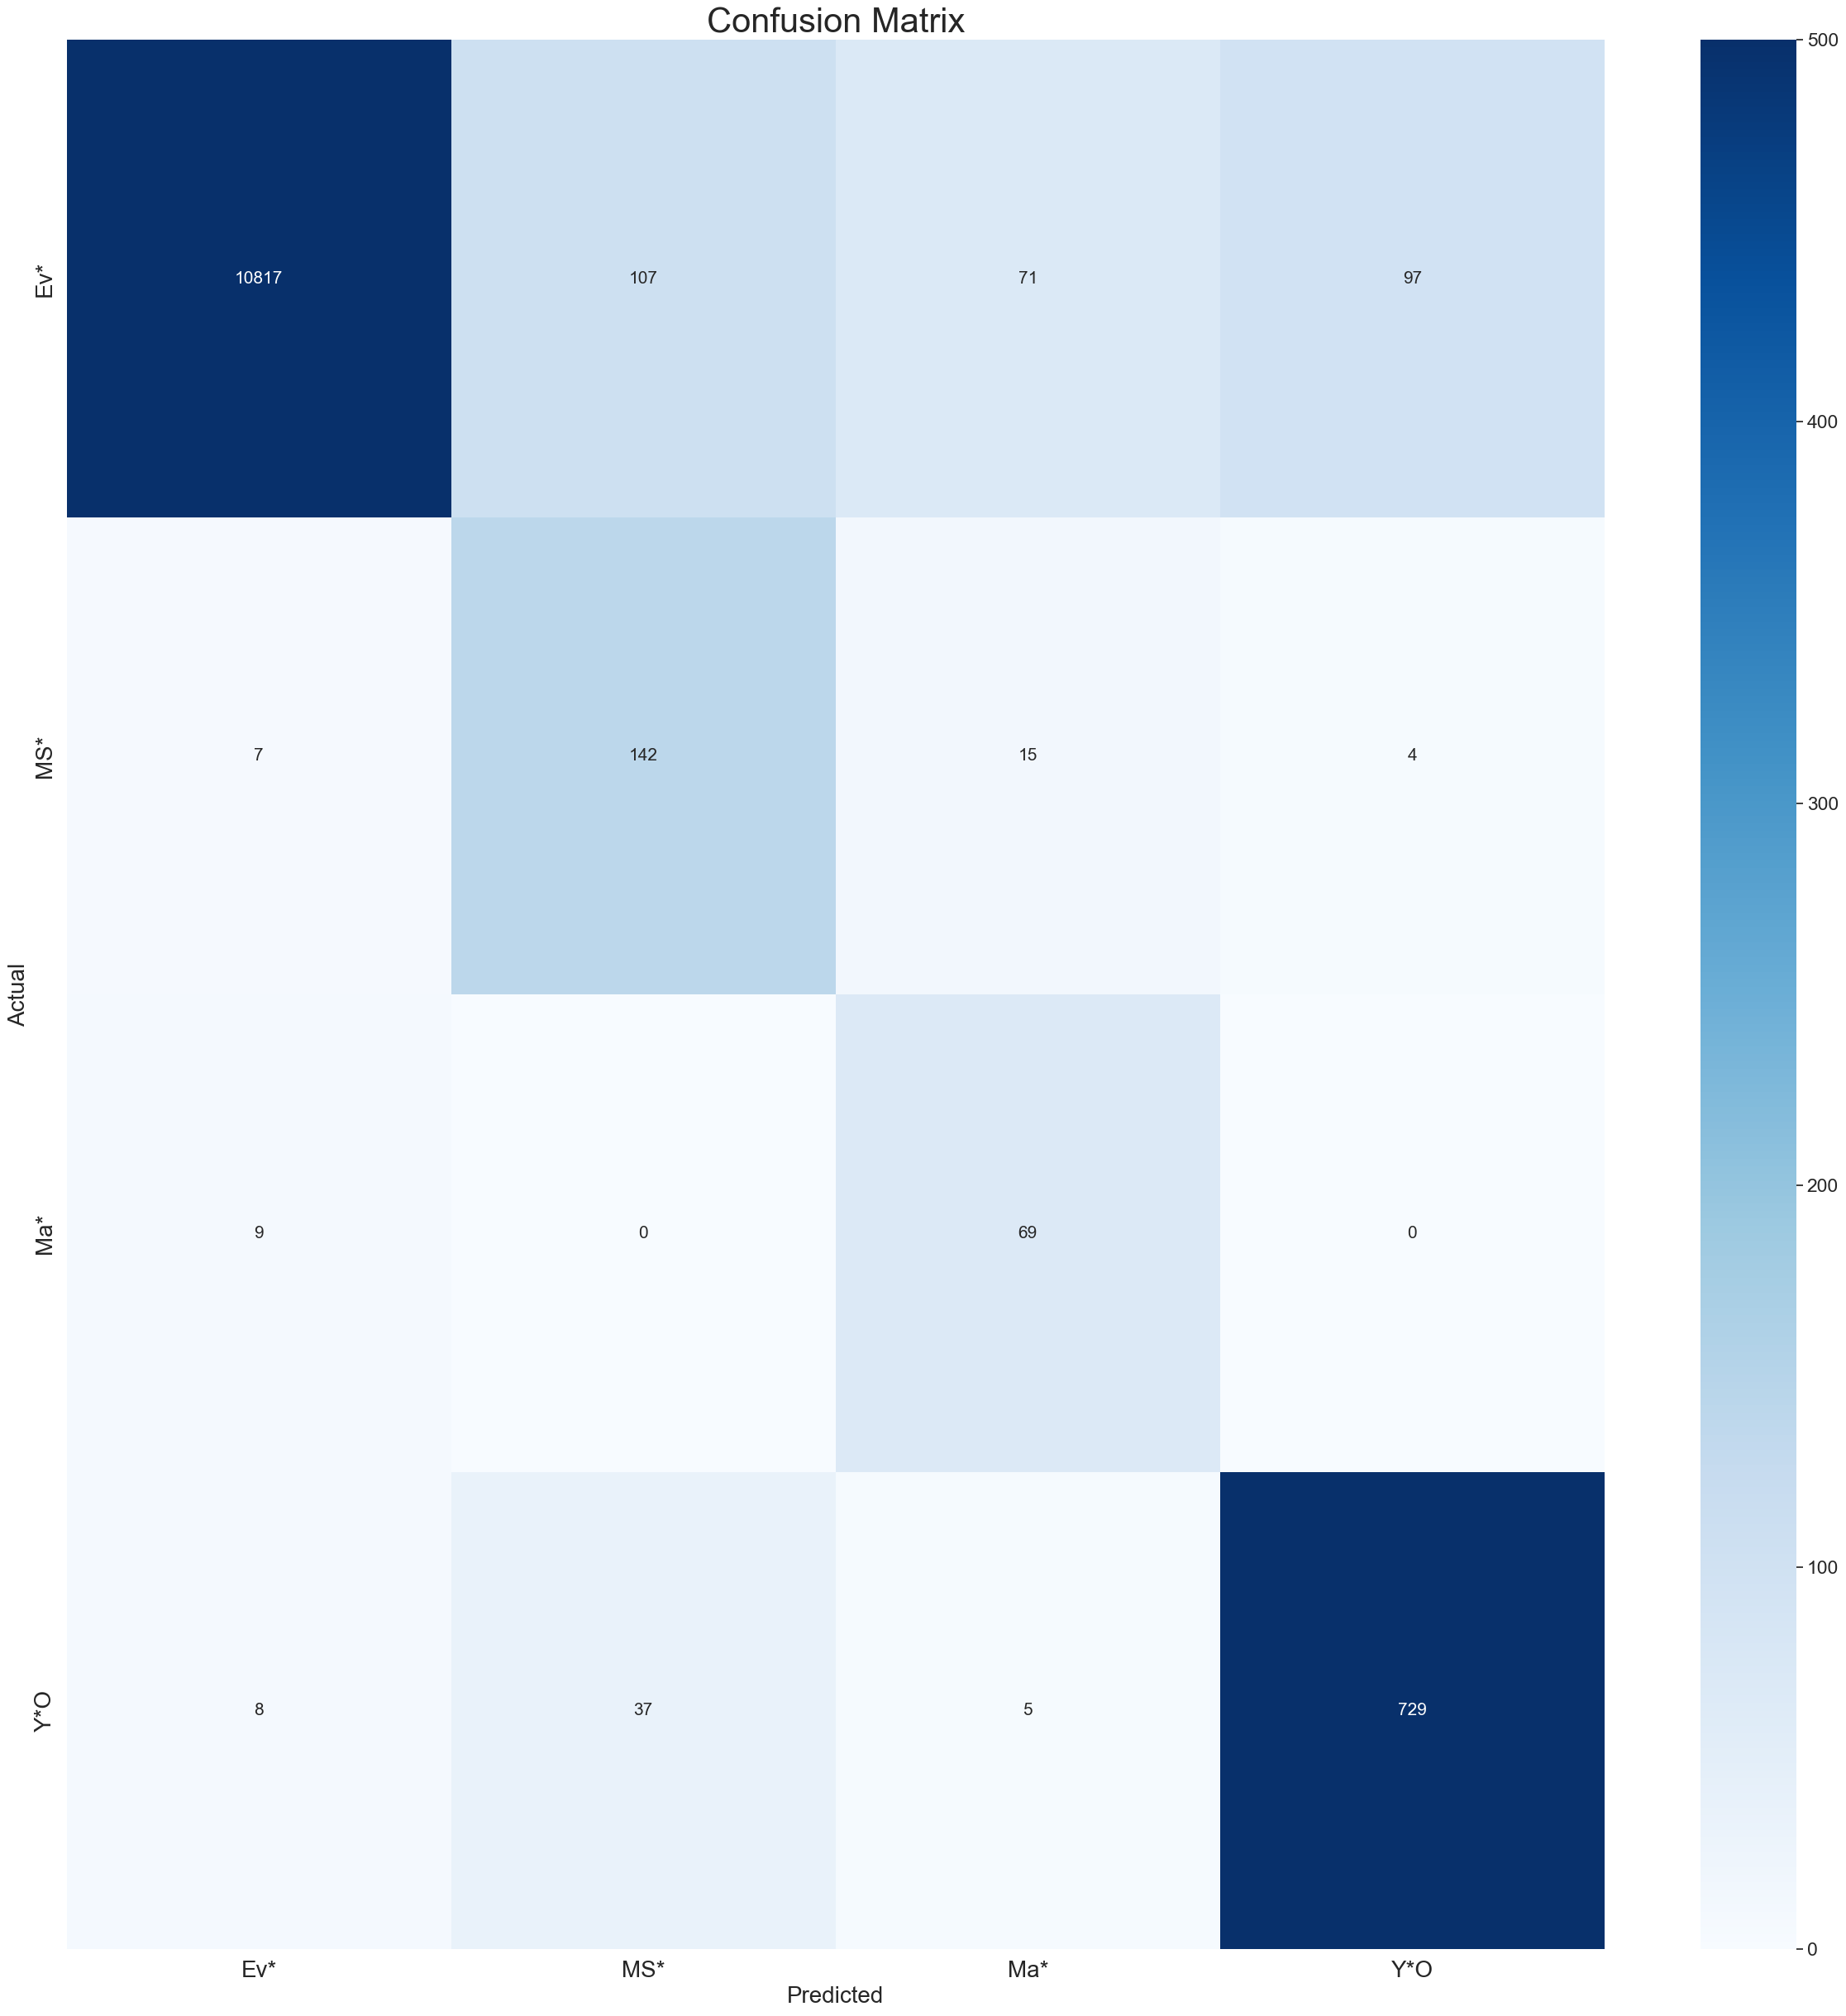

In [26]:
# Load the saved model
model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

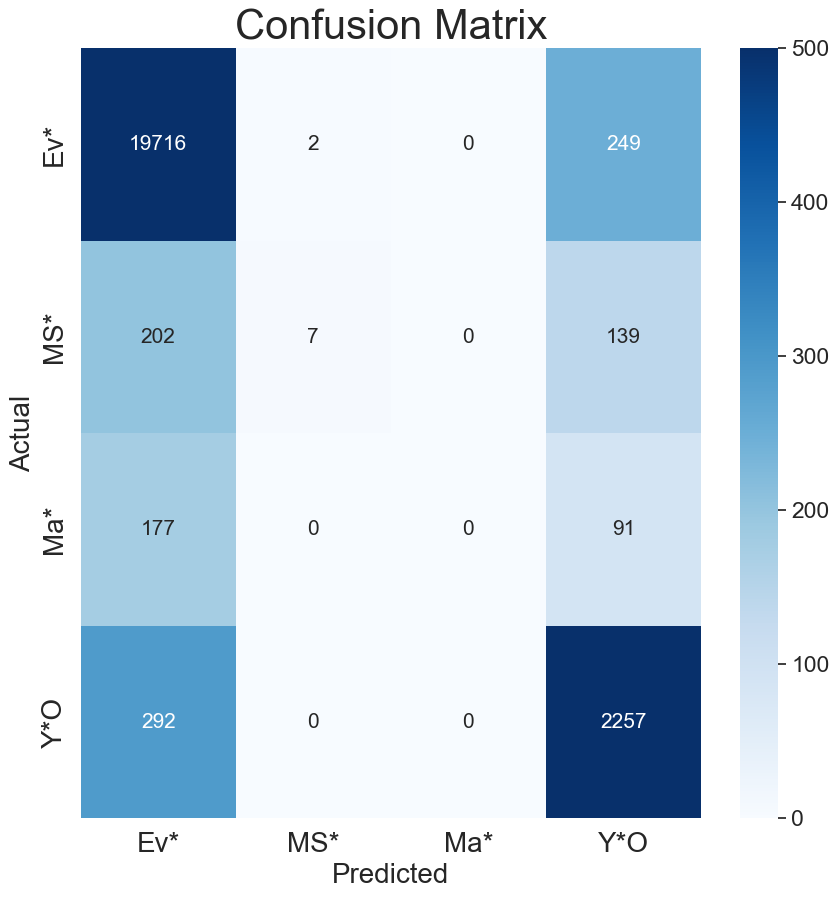

In [7]:
# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()